In [0]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
import os
import cv2
from glob import glob


Using TensorFlow backend.


# 1. Read the images and generate the train and test dataset (10 points)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile as zf
train_zip = zf.ZipFile('/content/drive/My Drive/R8/train.zip')
train_zip.extractall()
!ls

drive  sample_data  train


In [0]:
#see contents of train file
!ls train

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [0]:
#save the path into variable to use it easily next times.
TRAin_DATA_FOLDER= "train"

In [0]:
#Read images and remove missing values save images in images list
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missig value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

In [0]:
#number of all images
len(images)

4750

In [0]:
# resizing images
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

In [0]:
#save resized images into images.
images = [resize_images(img) for img in images]

In [0]:
images[0].shape

(256, 256, 3)

In [0]:
#see number of images in each lablel
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)
#for key,value in images_per_class.items():
   # print("number of {0} images is  -> {1}".format(key, len(value)))
  
for label in set(classes):

  print("number of {} images is  -> {}".format(
        label, 
        len(images[classes == label])))

images shape:  (4750, 256, 256, 3)
classes shape:  (4750,)
number of Scentless Mayweed images is  -> 516
number of Maize images is  -> 221
number of Common Chickweed images is  -> 611
number of Charlock images is  -> 390
number of Fat Hen images is  -> 475
number of Black-grass images is  -> 263
number of Shepherds Purse images is  -> 231
number of Common wheat images is  -> 221
number of Sugar beet images is  -> 385
number of Small-flowered Cranesbill images is  -> 496
number of Cleavers images is  -> 287
number of Loose Silky-bent images is  -> 654


Text(0.5, 0.98, 'Categorical Plotting')

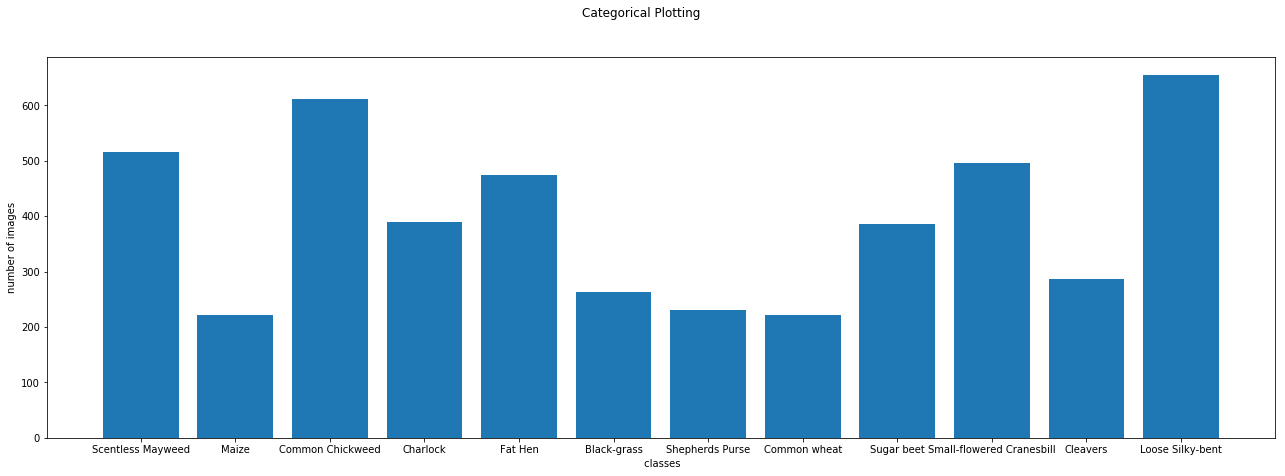

In [0]:
# plot the distrbution of number of images
values =[]
labels=[]
for label in set(classes):
  values.append(len(images[classes == label]))
  labels.append(label)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels, values)
ax.set_xlabel(" classes")
ax.set_ylabel("number of images")
#axs[1].scatter(label, )
  #axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')

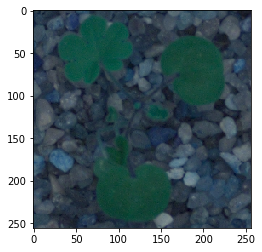

In [0]:
# look at image after resize
plt.imshow(images[50])

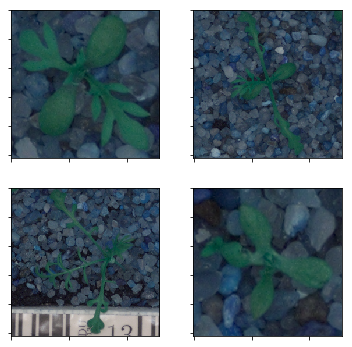

In [0]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("Scentless Mayweed")

In [0]:
img = cv2.imread("train/Scentless Mayweed/1300c3cd9.png")

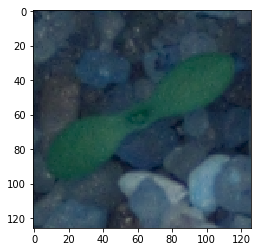

In [0]:
plt.imshow(img)

Apply image processing on the images
* convert image from RGB to HSV
* Apply closing opration(one of mophological opration)
* Apply segmentation
* Apply sharpening

In [0]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [0]:
# put all those functions together.

def segment(img):

  #image_mask = create_mask_for_plant(img)
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

In [0]:
# itrate on all images

for indx, image in enumerate(images):
  try:
     images[indx] = segment(image)
      
  except:
    print(indx)
    continue

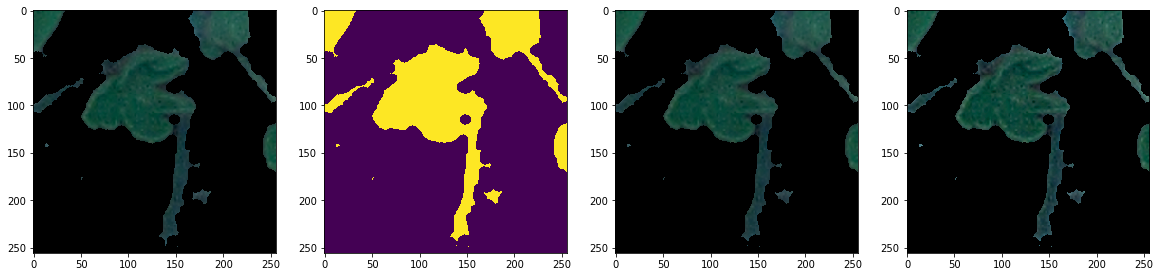

In [0]:
# plot sample image to see diffrence before and after
image = images[classes == "Small-flowered Cranesbill"][40]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

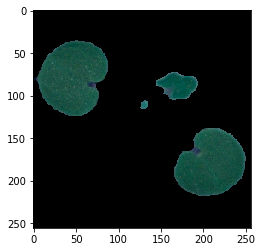

In [0]:
plt.imshow(images[0])

In [0]:
images.shape

(4750, 256, 256, 3)

# 2. Divide the data set into Train and validation data sets

In [0]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(classes)

In [0]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

In [0]:
X_train.shape

(3325, 256, 256, 3)

In [0]:
random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, Y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [0]:
print(X_test.shape)
print(X_val.shape)

(712, 256, 256, 3)
(713, 256, 256, 3)


# 3. Initialize & build the model (20 points)

In [0]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Set the CNN model 

batch_size = None

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size,256, 256, 3)))


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))



model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(12, activation = "softmax"))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)      36928     


In [0]:
opt = Adam(lr=0.001)

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [0]:
model.fit(X_train, y_train, epochs = 50, validation_data = (X_val,Y_val),batch_size = batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3325 samples, validate on 713 samples
Epoch 1/50
3325/3325 [==============================] - 60s 18ms/step - loss: 2.8200 - acc: 0.1308 - val_loss: 2.4422 - val_acc: 0.1781
Epoch 2/50
3325/3325 [==============================] - 46s 14ms/step - loss: 2.3913 - acc: 0.1627 - val_loss: 2.3353 - val_acc: 0.2020
Epoch 3/50
3325/3325 [==============================] - 46s 14ms/step - loss: 2.2360 - acc: 0.2250 - val_loss: 2.1463 - val_acc: 0.2749
Epoch 4/50
3325/3325 [==============================] - 46s 14ms/step - loss: 2.0503 - acc: 0.2671 - val_loss: 2.0554 - val_acc: 0.3254
Epoch 5/50
3325/3325 [==============================] - 46s 14ms/step - loss: 1.9829 - acc: 0.2899 - val_loss: 1.9369 - val_acc: 0.3338
Epoch 6/50
3325/3325 [==============================] - 46s 14ms/step - loss: 1.8520 - acc: 0.3200 - val_loss: 1.9229 - val_acc: 0.3254
Epoch 7/50
3325/3325 [=====================

In [0]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size = 38)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5623555689882697
Test accuracy: 0.7949438178807162


In [0]:
X_test.shape

(712, 256, 256, 3)

In [0]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 30
batch_size = 38

 # 4. Optimize the model (16 points)

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [0]:
X_train, X_test, y_train, y_test
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 66s - loss: 0.6783 - acc: 0.7822 - val_loss: 0.6874 - val_acc: 0.7532
Epoch 2/30
 - 62s - loss: 0.6559 - acc: 0.7922 - val_loss: 0.6719 - val_acc: 0.7616
Epoch 3/30
 - 63s - loss: 0.6494 - acc: 0.7865 - val_loss: 0.5005 - val_acc: 0.8177
Epoch 4/30
 - 63s - loss: 0.6501 - acc: 0.7904 - val_loss: 0.9323 - val_acc: 0.6620
Epoch 5/30
 - 62s - loss: 0.6238 - acc: 0.7883 - val_loss: 0.8128 - val_acc: 0.7223
Epoch 6/30
 - 63s - loss: 0.5639 - acc: 0.8079 - val_loss: 0.7869 - val_acc: 0.7882

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/30
 - 63s - loss: 0.4836 - acc: 0.8388 - val_loss: 0.5094 - val_acc: 0.8303
Epoch 8/30
 - 63s - loss: 0.4399 - acc: 0.8530 - val_loss: 0.5818 - val_acc: 0.7966
Epoch 9/30
 - 63s - loss: 0.4134 - acc: 0.8578 - val_loss: 0.5620 - val_acc: 0.8036
Epoch 10/30
 - 62s - loss: 0.4110 - acc: 0.8603 - val_loss: 0.6612 - val_acc: 0.7798

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.000250000011874362

In [0]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size = None)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5446435296803378
Test accuracy: 0.8258426966292135


# 5. Predict the accuracy for both train and validation data (14 points)

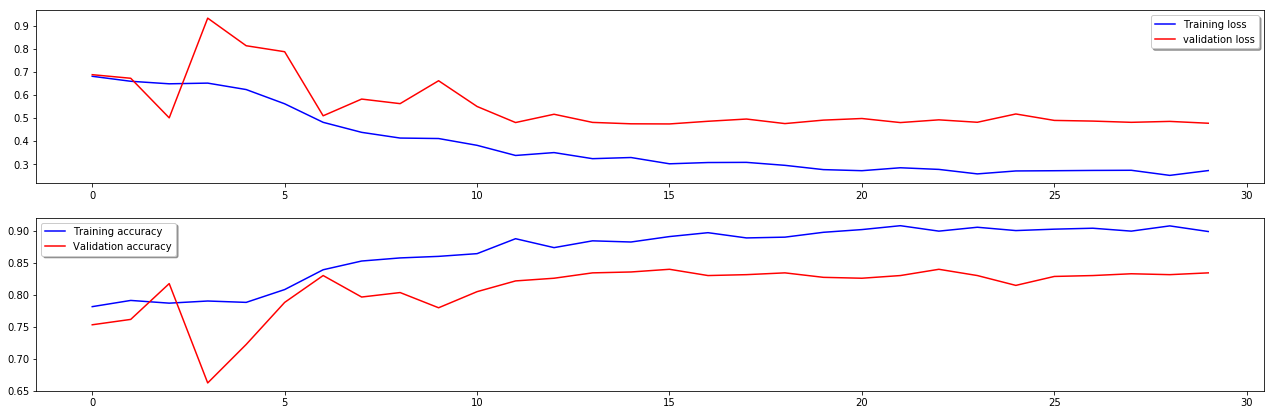

In [0]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Confusion Matrix

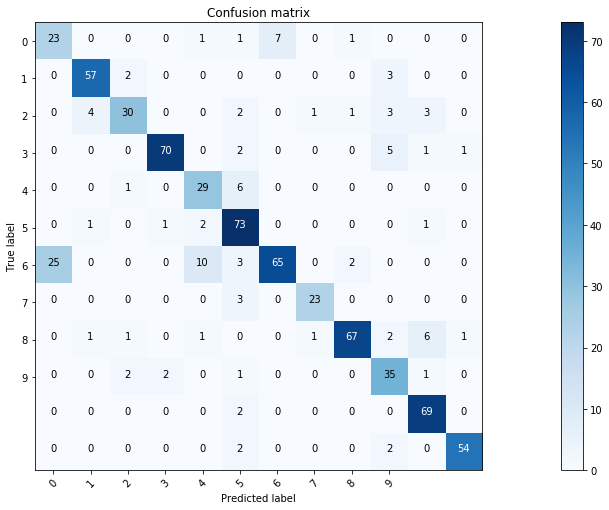

In [0]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [0]:
Predicted_classes = model.predict_classes(X_test)

In [0]:
wrong_preds = X_test[Predicted_classes != np.argmax(y_test)]

In [0]:
set(Predicted_classes)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [0]:
i = 10

Predicted class: Fat Hen
Actual class: Charlock


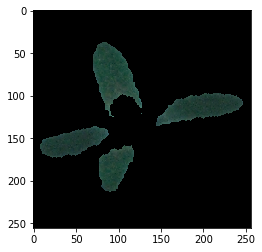

In [0]:
pred = model.predict_classes(np.array([wrong_preds[i]]))[0]
act = np.argmax(y_test[i])
print("Predicted class: {}".format(enc.classes_[pred]))
print("Actual class: {}".format(enc.classes_[act]))

plt.imshow(wrong_preds[i])

In [0]:
enc.inverse_transform(np.array([y_test[10]]))

array(['Charlock'], dtype='<U25')

In [0]:
enc.classes_

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype='<U25')